In [19]:
import numpy as np
import pandas as pd
import openai
import time
import os
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, \
    average_precision_score

%env OPENAI_API_KEY={api_key}

In [20]:
!openai api fine_tunes.results -i ft-3Y9OM0lDYq3nFKuAQ7cjwKgW > ../dataset/output/fine_tune_result.csv

In [21]:
results = pd.read_csv('../dataset/output/fine_tune_result.csv')

print("Plot" + str(results[results['classification/accuracy'].notnull()]['classification/accuracy']))
print("Plot" + str(results[results['classification/precision'].notnull()]['classification/precision']))
print("Plot" + str(results[results['classification/recall'].notnull()]['classification/recall']))
print("Plot" + str(results[results['classification/f1.0'].notnull()]['classification/f1.0']))
print("Plot" + str(results[results['classification/auroc'].notnull()]['classification/auroc']))

Plot594     1.0
1188    1.0
1783    1.0
2377    1.0
Name: classification/accuracy, dtype: float64
Plot594     1.0
1188    1.0
1783    1.0
2377    1.0
Name: classification/precision, dtype: float64
Plot594     1.0
1188    1.0
1783    1.0
2377    1.0
Name: classification/recall, dtype: float64
Plot594     1.0
1188    1.0
1783    1.0
2377    1.0
Name: classification/f1.0, dtype: float64
Plot594     1.0
1188    1.0
1783    1.0
2377    1.0
Name: classification/auroc, dtype: float64


In [22]:
test = pd.read_json('../dataset/input/emails_set_prepared_valid.jsonl', lines=True)

test = test.head(59)


In [23]:
openai.api_key = os.environ.get('OPENAI_API_KEY')

In [24]:
attempt = 0
responses = []
ft_model = "ada:ft-personal:binary-email-classification-2023-04-22-22-06-56"
start = False

In [25]:
for index, row in test.iterrows():
    response = {}
    try:
        if attempt % 60 == 0 and start:
            time.sleep(60)

        start = True
        res = openai.Completion.create(model=ft_model,
                                       prompt=row.prompt + '\n\n###\n\n',
                                       max_tokens=1,
                                       temperature=0,
                                       logprobs=10)

        response["value"] = int(res['choices'][0]['text'])
        response["actual"] = row.completion
        response["probability_of_true"] = res['choices'][0]['logprobs']['top_logprobs'][0][" 1"]
        response["probability_of_false"] = res['choices'][0]['logprobs']['top_logprobs'][0][" 0"]
        responses.append(response)

        print(response)
        attempt += 1

    except Exception as e:
        print(f"Error: {e}")
        pass

{'value': 0, 'actual': 0, 'probability_of_true': -12.901758, 'probability_of_false': -9.72699e-06}
{'value': 0, 'actual': 0, 'probability_of_true': -12.0964, 'probability_of_false': -1.0561456e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -12.130394, 'probability_of_false': -2.1649737e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -12.845539, 'probability_of_false': -8.0580685e-06}
{'value': 0, 'actual': 0, 'probability_of_true': -12.23176, 'probability_of_false': -3.2616e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -10.824798, 'probability_of_false': -4.6684505e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -12.42638, 'probability_of_false': -6.38515e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -10.67567, 'probability_of_false': -3.0947078e-05}
{'value': 0, 'actual': 0, 'probability_of_true': -10.847038, 'probability_of_false': -5.944078e-05}
Error: ' 1'
{'value': 1, 'actual': 1, 'probability_of_true': -1.7595703e-05, 'probability_of_false': -12

In [26]:
result = pd.DataFrame(responses)

In [27]:
actual = np.array(result['actual'])
predicted = np.array(result['value'])
probs = np.array(result['probability_of_true'])

In [28]:
# Print accuracy
accuracy = accuracy_score(actual, predicted)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


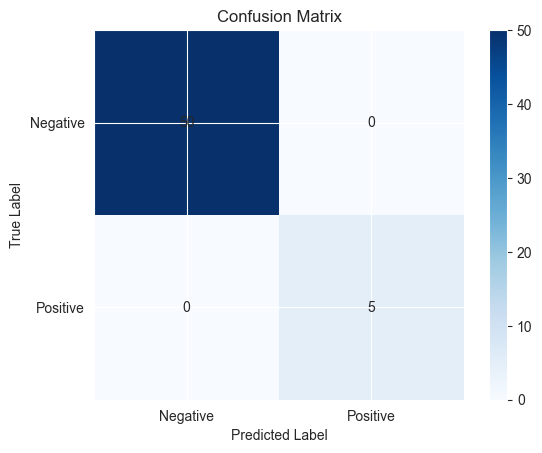

In [29]:
# Plot confusion matrix
conf_matrix = confusion_matrix(actual, predicted)

plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center')
plt.show()

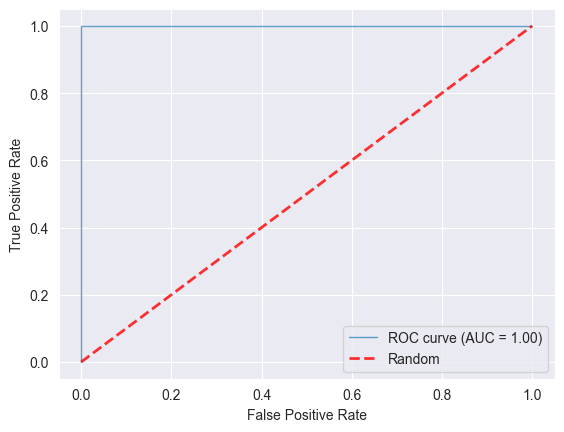

In [30]:
# ROC curve
fpr, tpr, thresholds = roc_curve(actual, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.7,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

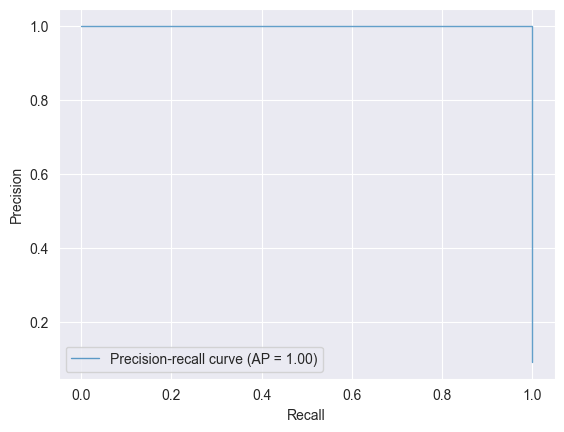

In [31]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(actual, probs)
average_precision = average_precision_score(actual, probs)
plt.plot(recall, precision, lw=1, alpha=0.7,
         label='Precision-recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

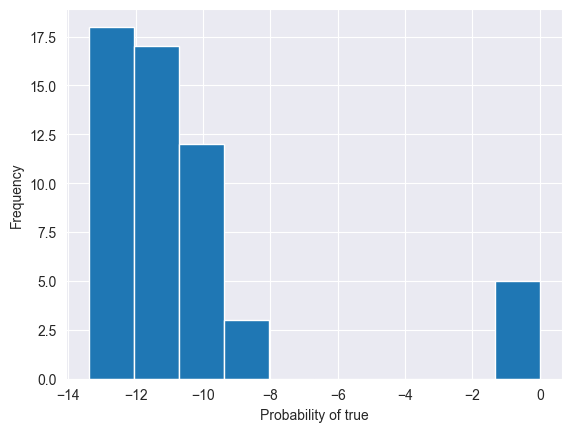

In [32]:
# Histogram of probabilities
plt.hist(probs, bins=10)
plt.xlabel('Probability of true')
plt.ylabel('Frequency')
plt.show()